#Prototypical Netwoks on the Omniglot dataset - 200088D

##Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

##Import data

In [2]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2024-09-10 03:43:57--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2024-09-10 03:43:58--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.02s   

2024-09-10 03:43:58 (346 MB/s) - ‘images_evaluation.zip’ saved

In [3]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

##Read data

1,623 distinct handwritten characters from 50 different alphabets can be found in the Omniglot collection. 20 distinct individuals (i.e., 20 instances per character) used Amazon Mechanical Turk to draw each of the 1623 characters.
There are two sets of alphabets included in it: a backdrop set of thirty and an assessment set of twenty. The evaluation set will be used for testing, and the background set for training.


In [4]:
def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    datax = []
    datay = []
    characters = os.listdir(alphabet_directory_path)
    for character in characters:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.resize(
                cv2.imread(alphabet_directory_path + character + '/' + img),
                (28,28)
                )
            #rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            datax.extend((image, rotated_90, rotated_180, rotated_270))
            datay.extend((
                alphabet_directory_name + '_' + character + '_0',
                alphabet_directory_name + '_' + character + '_90',
                alphabet_directory_name + '_' + character + '_180',
                alphabet_directory_name + '_' + character + '_270'
            ))
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_alphabets,
                          args=(
                              base_directory + '/' + directory + '/', directory,
                              )) for directory in os.listdir(base_directory)]
    pool.close()
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [5]:
trainx, trainy = read_images('images_background')

In [6]:
testx, testy = read_images('images_evaluation')

In [7]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120, 28, 28, 3), (77120,), (52720, 28, 28, 3), (52720,))

##Create samples

In [8]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [9]:
def display_sample(sample):
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

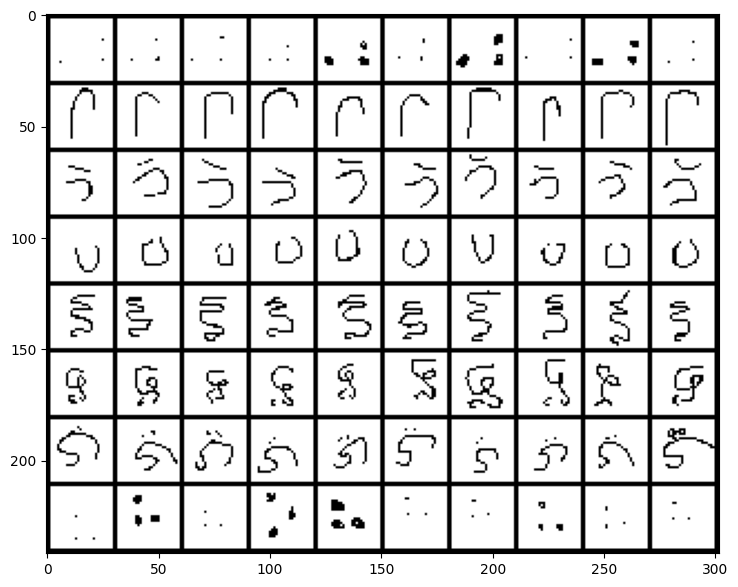

In [10]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [11]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

##Build model

In [12]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )

  return ProtoNet(encoder)

In [13]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]

    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()

    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)

    z = self.encoder.forward(x)
    z_dim = z.size(-1)
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    dists = euclidean_dist(z_query, z_proto)

    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [14]:
def euclidean_dist(x, y):
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

##Train

In [15]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [16]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0
  stop = False

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [17]:

model = load_protonet_conv(
    x_dim=(3,28,28),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

<ipython-input-16-80080a0811ea>:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.1122 Acc: 0.9653


Epoch 2 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0457 Acc: 0.9837


Epoch 3 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0343 Acc: 0.9872


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0288 Acc: 0.9887


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0260 Acc: 0.9899


##Test

In [18]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [19]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

<ipython-input-18-7d44072d12d3>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0192 Acc: 0.9961


##Test on specific example

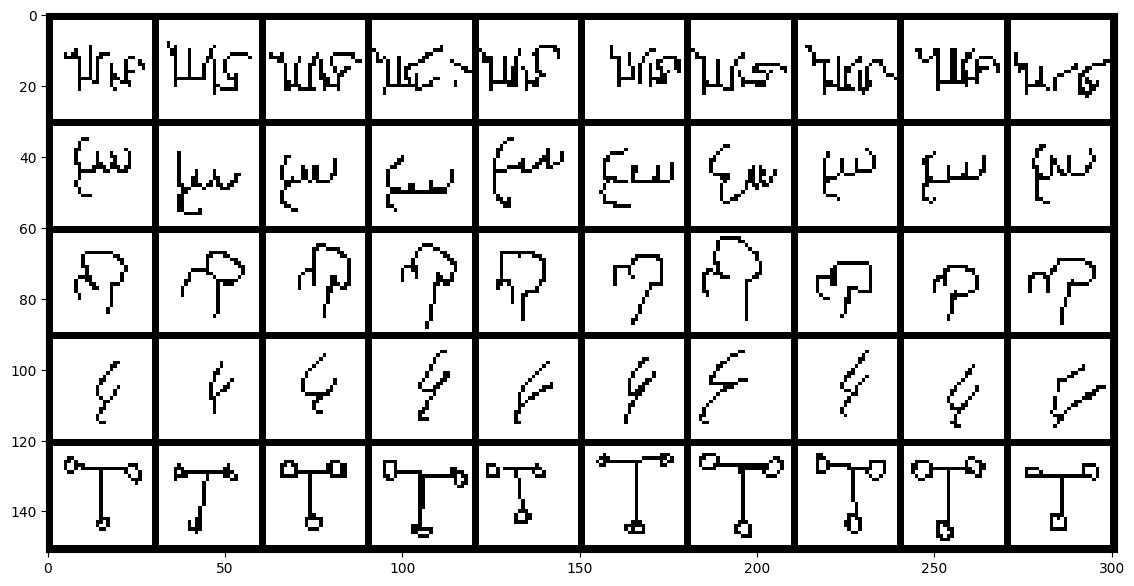

In [20]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [21]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [22]:
my_output

{'loss': 0.001329383929260075,
 'acc': 1.0,
 'y_hat': tensor([[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}